Created on Tue Apr 21 11:10:11 2020

@author: Deeps

In [2]:
import warnings
warnings.filterwarnings("ignore")
#!pip install torch
#!pip install torchsummary
#! pip install torchvision

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Displays a progress bar

import torch
from torch.utils import data
from torchsummary import summary
from torch import nn
from torch import optim
from PIL import Image
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.nn.functional as F
from torchvision import datasets,models, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from data_gen import Dataset
from augment import Augmentations as aug
from visualization  import visualizer 

## Load the dataset and train, val, test splits

In [5]:
num_epochs = 20
num_classes = 2
batch_size = 8
learning_rate = 0.001
image_size = (748,500)
resnet_resize = (224,224)
datacsv = pd.read_csv("data.csv")

cv_results = []

### ------------Data Augmentation--------

In [6]:
data_base_aug = dict(datacsv)
data_base_aug["image"] = list(data_base_aug["image"])
data_base_aug["label"] = list(data_base_aug["label"])

rot = aug()
for k in range(len(data_base_aug["image"])):
    result = rot.rotate_append(data_base_aug["image"][k],data_base_aug["label"][k])
    datacsv = datacsv.append(result,ignore_index = True)

_____

# ----------Create dataset generator-------------

In [11]:
for cv in range(1):
    x_train,x_test =tts(datacsv["image"],test_size=1/6, shuffle=False)
    partition = {'train':list(x_train),'validation':list(x_test)}
    labels = {}
    
    for k in range(len(datacsv['image'])):
        labels['%s'%datacsv['image'][k]] = datacsv['label'][k]
        
    #####################################################################
    
    training_set = Dataset(partition["train"],labels, image_size)
    training_generator = data.DataLoader(training_set, batch_size=batch_size, shuffle=False)
    
    validation_set = Dataset(partition['validation'], labels, image_size)
    validation_generator = data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    
    
    #######################################################
    class Network(nn.Module):
        def __init__(self):
            super().__init__()
            self.resnet =  torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
            self.num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(self.num_ftrs,8)
            self.fc1 = nn.Linear(8, num_classes)
            
        def forward(self,x):
            # TODO: Design your own network, implement forward pass here
            x = F.relu(self.resnet(x)) #3*748*512 -> 6*744*508 -> 6*372*254
            out = F.softmax(self.fc1(x))
            return out
    
    device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
    model = Network().to(device)
    
    ct = 0 
    model_size = len([1 for k in model.children()])
    print("model components: ", model-size)
    for child in model.children():
        ct+=1
        if ct==1:
            for param in child.parameters():
                param.requires_grad=False
    
    model.resnet.fc.weight.requires_grad = True
    model.resnet.fc.bias.requires_grad = True
    model.fc1.weight.requires_grad = True
    model.fc1.bias.requires_grad = True
    
    summary(model,(3,resnet_resize[0],resnet_resize[1]))
    criterion = nn.CrossEntropyLoss() # Specify the loss layer
    optimizer = optim.SGD(model.parameters(),lr=0.0008,momentum=0.9) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength
       
    
    def train(model, training_generator, num_epoch = num_epochs): # Train the model
        print("Start training...")
        model.train() # Set the model to training mode
        for i in range(num_epoch):
            running_loss = []
            accuracy = []
            for batch, label in tqdm(training_generator):
                batch = batch.to(device)
                label = label.to(device)
                optimizer.zero_grad() # Clear gradients from the previous iteration
                pred = model(batch) # This will call Network.forward() that you implement
                loss = criterion(pred, label) # Calculate the loss
                running_loss.append(loss.item())
                correct = (torch.argmax(pred,dim=1)==label).sum().item()
                accuracy.append(correct/batch_size)
                loss.backward() # Backprop gradients to all tensors in the network
                optimizer.step() # Update trainable weights
            print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
        print("Done!")
        try:
            torch.save(model, "Trained_model/teeth_model.pth")
            print("Model saved!")
        except:
            print("Could not save model")
    
    def evaluate(model, validation_generator): # Evaluate accuracy on validation / test set
        model.eval() # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.set_grad_enabled(True): # Do not calculate grident to speed up computation
            for batch, label in tqdm(validation_generator):
                batch = batch.to(device)
                label = label.to(device)
                pred = model(batch)
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
                total+=batch_size
        acc = correct/total
        print("Evaluation accuracy: {}".format(acc))
        return acc
        
    train(model, training_generator, num_epochs)
    print("Evaluate on validation set...")
    result = evaluate(model, validation_generator)
    cv_results.append(result)

  4%|▍         | 1/25 [00:00<00:03,  7.19it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 742, 496]             636
         MaxPool2d-2          [-1, 6, 371, 248]               0
            Conv2d-3         [-1, 12, 366, 244]           2,172
         MaxPool2d-4         [-1, 12, 183, 122]               0
            Conv2d-5          [-1, 6, 178, 118]           2,166
         MaxPool2d-6            [-1, 6, 89, 59]               0
            Conv2d-7            [-1, 3, 86, 56]             291
         MaxPool2d-8            [-1, 3, 43, 28]               0
            Linear-9                  [-1, 512]       1,849,856
           Linear-10                    [-1, 2]           1,026
Total params: 1,856,147
Trainable params: 1,856,147
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.28
Forward/backward pass size (MB): 32.62
Params size (MB): 7.08
Estima

  4%|▍         | 1/25 [00:00<00:03,  6.73it/s]

Epoch 1 loss:0.6955504298210144


  4%|▍         | 1/25 [00:00<00:03,  6.85it/s]

Epoch 2 loss:0.6796303606033325


  4%|▍         | 1/25 [00:00<00:03,  6.71it/s]

Epoch 3 loss:0.6591836833953857


  4%|▍         | 1/25 [00:00<00:03,  6.68it/s]

Epoch 4 loss:0.6296751809120178


  4%|▍         | 1/25 [00:00<00:03,  7.11it/s]

Epoch 5 loss:0.5800417304039002


  4%|▍         | 1/25 [00:00<00:03,  6.78it/s]

Epoch 6 loss:0.5139015471935272


  4%|▍         | 1/25 [00:00<00:03,  7.16it/s]

Epoch 7 loss:0.46665343165397644


  4%|▍         | 1/25 [00:00<00:03,  7.10it/s]

Epoch 8 loss:0.45019332647323607


  4%|▍         | 1/25 [00:00<00:03,  7.02it/s]

Epoch 9 loss:0.44521239042282107


  4%|▍         | 1/25 [00:00<00:03,  7.19it/s]

Epoch 10 loss:0.4429254937171936


  4%|▍         | 1/25 [00:00<00:03,  7.24it/s]

Epoch 11 loss:0.44199928641319275


  4%|▍         | 1/25 [00:00<00:03,  7.16it/s]

Epoch 12 loss:0.4416111862659454


  4%|▍         | 1/25 [00:00<00:03,  7.16it/s]

Epoch 13 loss:0.44115815877914427


  4%|▍         | 1/25 [00:00<00:03,  7.11it/s]

Epoch 14 loss:0.44091638922691345


  4%|▍         | 1/25 [00:00<00:03,  7.17it/s]

Epoch 15 loss:0.4407646059989929


  4%|▍         | 1/25 [00:00<00:03,  7.13it/s]

Epoch 16 loss:0.4406078338623047


  4%|▍         | 1/25 [00:00<00:03,  7.28it/s]

Epoch 17 loss:0.4405087995529175


  4%|▍         | 1/25 [00:00<00:03,  7.15it/s]

Epoch 18 loss:0.4404423439502716


  4%|▍         | 1/25 [00:00<00:03,  7.12it/s]

Epoch 19 loss:0.4403926205635071


 20%|██        | 1/5 [00:00<00:00,  8.87it/s]

Epoch 20 loss:0.4402978384494782
Done!
Model saved!
Evaluate on validation set...


100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

Evaluation accuracy: 0.925


In [ ]:
print("Mean accuracy: %s"%(np.mean(cv_results)*100))

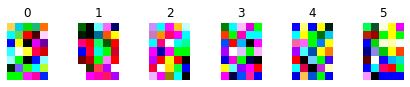

In [12]:
vis=visualizer()
vis.plot_filter(layer=model.conv1,single_channel = False)

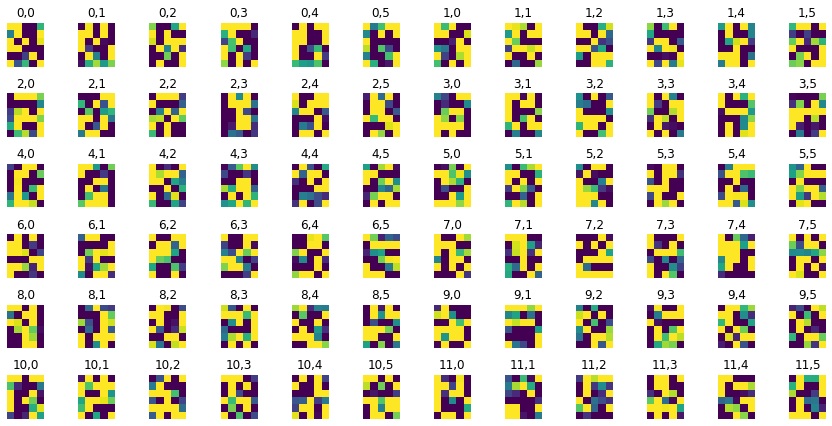

In [13]:
vis.plot_filter(layer=model.conv2,single_channel = True)

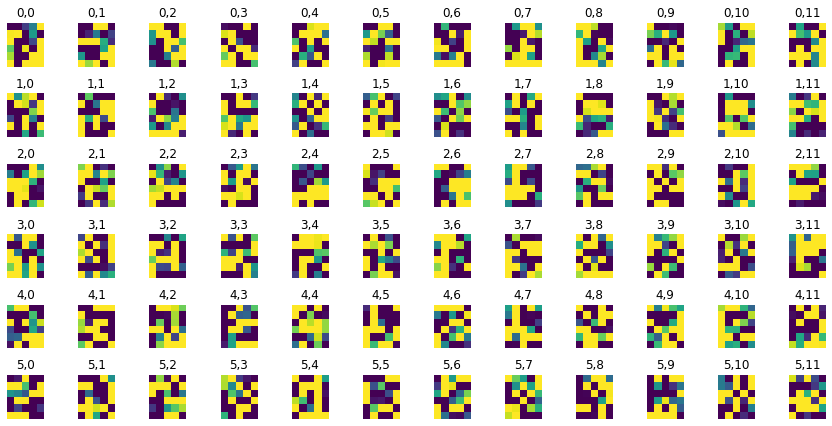

In [14]:
vis.plot_filter(layer=model.conv3,single_channel = True)

In [ ]:
vis.plot_filter(layer=model.conv4,single_channel = True)

In [ ]:
vis.plot_filter(layer=model.fc1,single_channel = False)